# Introduction

This notebook aims to test some classifiers when there is an unbalanced target.

The dataset is Statlog (Shuttle) from:

https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29

which contains 9 numerical features and the target is labeled in 7 groups with approximately 80% of the observations belonging to class 1. Classes 6 and 7 have respectively 6 and 11 observations among 58000 total observations.  

In order to manage the unbalanced classes I will perform the following steps:

- Prepare train and test sets manually in order to guarantee a minimum sample number for each class
- Use class_weight parameter to automatically adjust weights applied to class frequencies in the data
- Test some algorithms separately and with voting

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

# Importing the dataset

In [3]:
orig_train = pd.read_csv("train_shuttle.csv", encoding = "ISO-8859-1", sep=',', header=None)
orig_test = pd.read_csv("test_shuttle.csv", encoding = "ISO-8859-1", sep=',', header=None)

In [4]:
train = orig_train.copy()
test = orig_test.copy()

In [5]:
# Rename columns
columns_names = {0: 'a',
                 1: 'b',
                 2: 'c',
                 3: 'd',
                 4: 'e',
                 5: 'f',
                 6: 'g',
                 7: 'h',
                 8: 'j',
                 9: 'target'}

In [6]:
train = train.rename(columns=columns_names)

In [7]:
test = test.rename(columns=columns_names)

# A quick glance at the data

In [8]:
pd.concat([train, test], axis=0).drop(columns='target').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58000 entries, 0 to 14499
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   a       58000 non-null  int64
 1   b       58000 non-null  int64
 2   c       58000 non-null  int64
 3   d       58000 non-null  int64
 4   e       58000 non-null  int64
 5   f       58000 non-null  int64
 6   g       58000 non-null  int64
 7   h       58000 non-null  int64
 8   j       58000 non-null  int64
dtypes: int64(9)
memory usage: 4.4 MB


In [9]:
train.target.value_counts()

1    34108
4     6748
5     2458
3      132
2       37
7       11
6        6
Name: target, dtype: int64

<Axes: xlabel='target', ylabel='Count'>

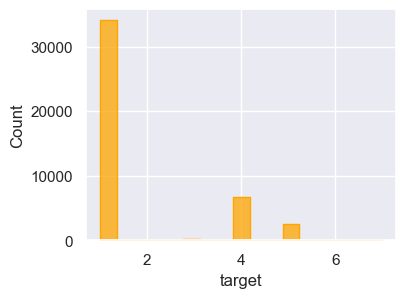

In [10]:
# plot target
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sns.histplot(x='target', data=train, element="step", color="orange")

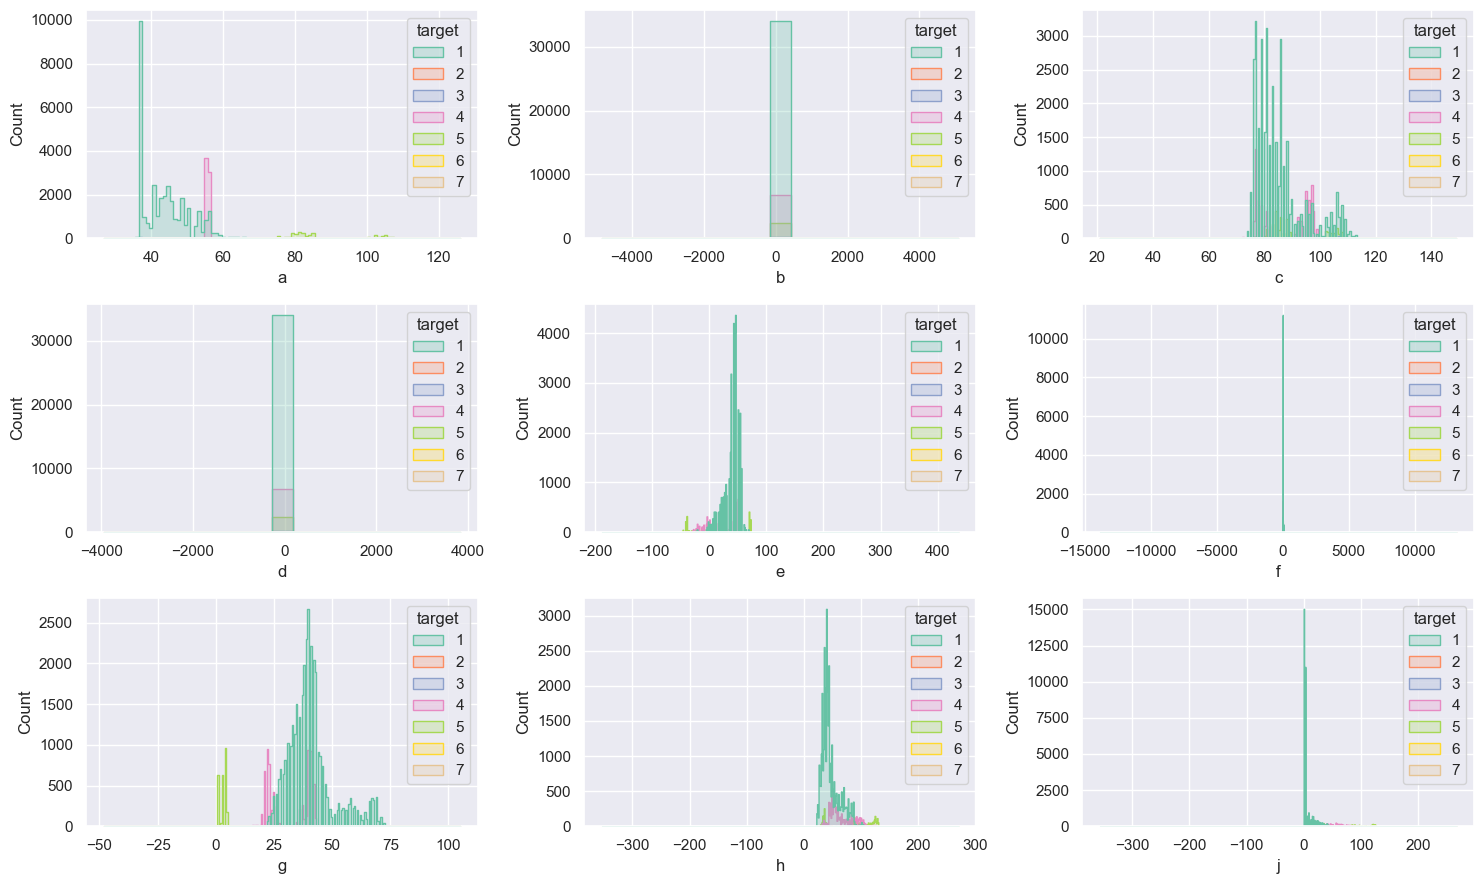

In [11]:
# feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15,9))

for ax, i in zip(axes.flat, range(9)):
    sns.histplot(ax=ax, x=train.iloc[:,i], data=train, element="step", palette="Set2", hue=train.target)
    
fig.tight_layout()

In [12]:
# dataset summary
train.describe()

a             b             c             d             e  \
count  43500.000000  43500.000000  43500.000000  43500.000000  43500.000000   
mean      48.249747     -0.205126     85.341563      0.262736     34.528782   
std       12.252618     78.142770      8.908602     41.004131     21.703409   
min       27.000000  -4821.000000     21.000000  -3939.000000   -188.000000   
25%       38.000000      0.000000     79.000000      0.000000     26.000000   
50%       45.000000      0.000000     83.000000      0.000000     42.000000   
75%       55.000000      0.000000     89.000000      0.000000     46.000000   
max      126.000000   5075.000000    149.000000   3830.000000    436.000000   

                  f             g             h             j        target  
count  43500.000000  43500.000000  43500.000000  43500.000000  43500.000000  
mean       1.298276     37.074552     50.899862     13.964598      1.700529  
std      179.486760     13.135557     21.463250     25.648404      1.354648  
min   -13839.000000    -48.000000   -353.000000   -356.000000      1.000000  
25%       -5.000000     31.000000     37.000000      0.000000      1.000000  
50%        0.000000     39.000000     44.000000      2.000000      1.000000  
75%        5.000000     42.000000     60.000000     14.000000      1.000000  
max    13148.000000    105.000000    270.000000    266.000000      7.000000

<Axes: >

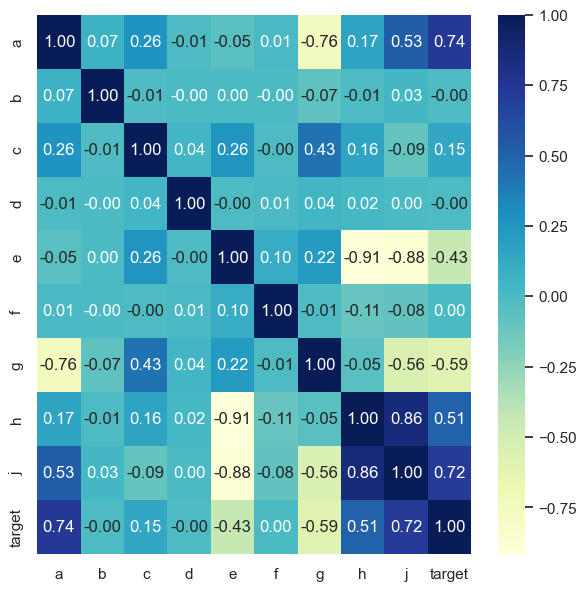

In [13]:
# correlation
fig = plt.figure(figsize=(7,7))
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap="YlGnBu")

In [14]:
# remove class 1
tmp_train = train.loc[train.target != 1]

<Axes: xlabel='target', ylabel='Count'>

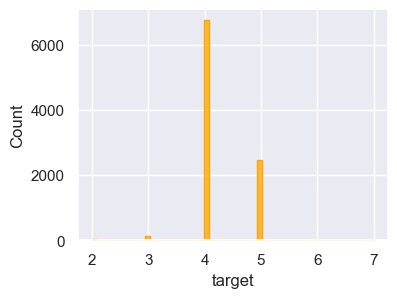

In [15]:
# plot target without class 1
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sns.histplot(x='target', data=tmp_train, element="step", color="orange")

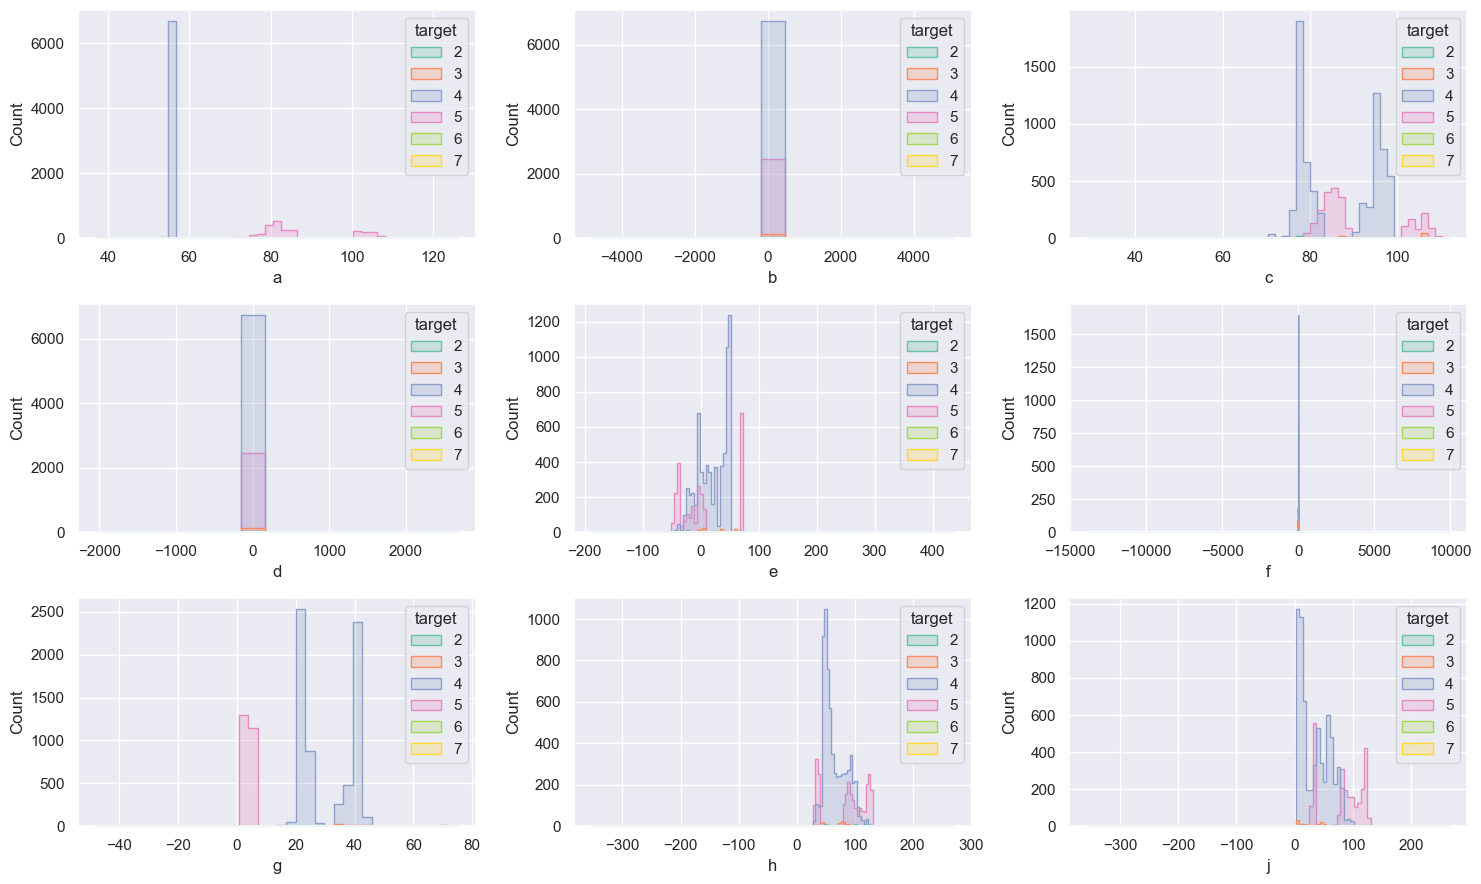

In [16]:
# feature distributions without class 1
fig, axes = plt.subplots(3, 3, figsize=(15,9))

for ax, i in zip(axes.flat, range(9)):
    sns.histplot(ax=ax, x=tmp_train.iloc[:,i], data=tmp_train, element="step", palette="Set2", hue=tmp_train.target)
    
fig.tight_layout()

In [17]:
# count value in feature b
train.b.value_counts().head(20)

 0     26925
-1      2903
 1      2777
 2      1711
-2      1656
 3      1535
 4      1244
 5      1136
-3      1131
-4      1033
-5       911
 6        46
-6        45
-8        22
-7        18
 7        16
 8        14
-11       13
-42       10
-33       10
Name: b, dtype: int64

In [18]:
# count value in feature d
train.d.value_counts().head(20)

 0     28477
-1      2150
 1      1701
-2      1557
 2      1232
-3      1205
 3       969
-4       818
 4       785
 5       710
-6       690
 6       661
-5       652
-7       594
 8       573
 7       402
-8        48
 9        20
-11       14
-9        14
Name: d, dtype: int64

In [19]:
# count value in feature f
train.f.value_counts().head(20)

 0     13865
-1       989
 1       975
-3       897
-4       876
-2       871
-6       841
 3       829
 6       817
 2       796
 5       792
 4       776
-5       762
 7       641
-7       626
-8       599
 8       583
 9       578
 10      559
 11      538
Name: f, dtype: int64

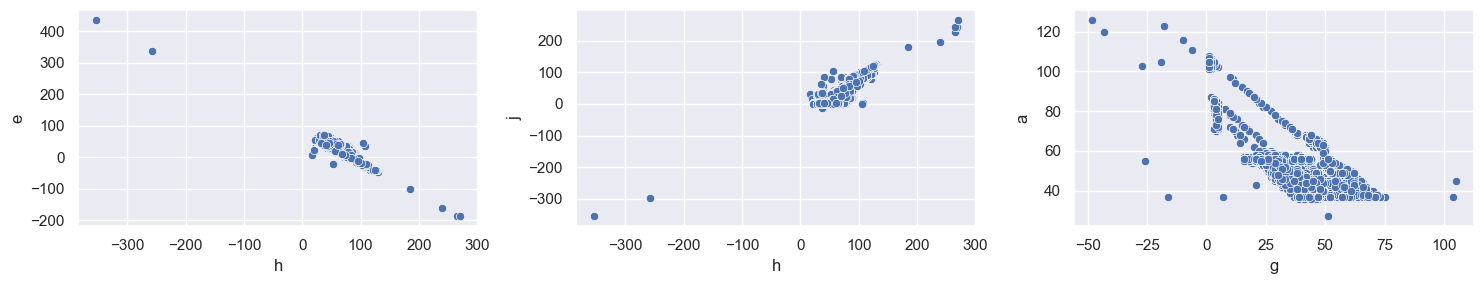

In [20]:
# plot highly correlated features
fig, axes = plt.subplots(1, 3, figsize=(15,3))

sns.scatterplot(ax=axes[0], x=train.h, y=train.e, data=train)
sns.scatterplot(ax=axes[1], x=train.h, y=train.j, data=train)
sns.scatterplot(ax=axes[2], x=train.g, y=train.a, data=train)

fig.tight_layout()

<Axes: >

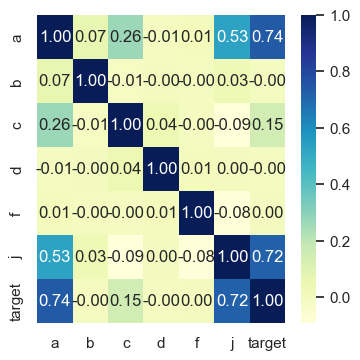

In [21]:
# correlation without highly correlated features
fig = plt.figure(figsize=(4,4))
corrMatrix = train.drop(columns=['h', 'g', 'e']).corr()
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap="YlGnBu")

# Test Logistic Regression

In [22]:
X = train.drop(columns=['h', 'g', 'e']).copy()

In [23]:
model1 = LogisticRegression(multi_class='ovr', class_weight='balanced')
model1.fit(X.drop(columns='target'), X.target)
pred1 = model1.predict_proba(X.drop(columns='target'))
l_odds1 = np.log(pred1 / (1 - pred1))

In [26]:
print(classification_report(X.target, model1.predict(X.drop(columns='target'))))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98     34108
           2       0.46      0.70      0.55        37
           3       0.67      0.71      0.69       132
           4       0.82      0.99      0.90      6748
           5       1.00      0.99      1.00      2458
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        11

    accuracy                           0.96     43500
   macro avg       0.56      0.62      0.59     43500
weighted avg       0.97      0.96      0.96     43500



In [27]:
def linearity_plot(df, nclass, l_odds):
    """Plot predictors vs linked prediction"""
    fig, axes = plt.subplots(2, 4, figsize=(20,6))

    for ax, i in zip(axes.flat, range(6)):
        flt = df.loc[df.target == nclass].index.values
        smoothed = sm.nonparametric.lowess(exog=df.iloc[flt,i], endog=l_odds[flt,nclass-1], frac=1)
        sns.scatterplot(ax=ax, y=l_odds[flt,nclass-1], x=df.iloc[flt,i])
        ax.plot(smoothed[:, 0], smoothed[:, 1], c="r")
    
    fig.tight_layout()

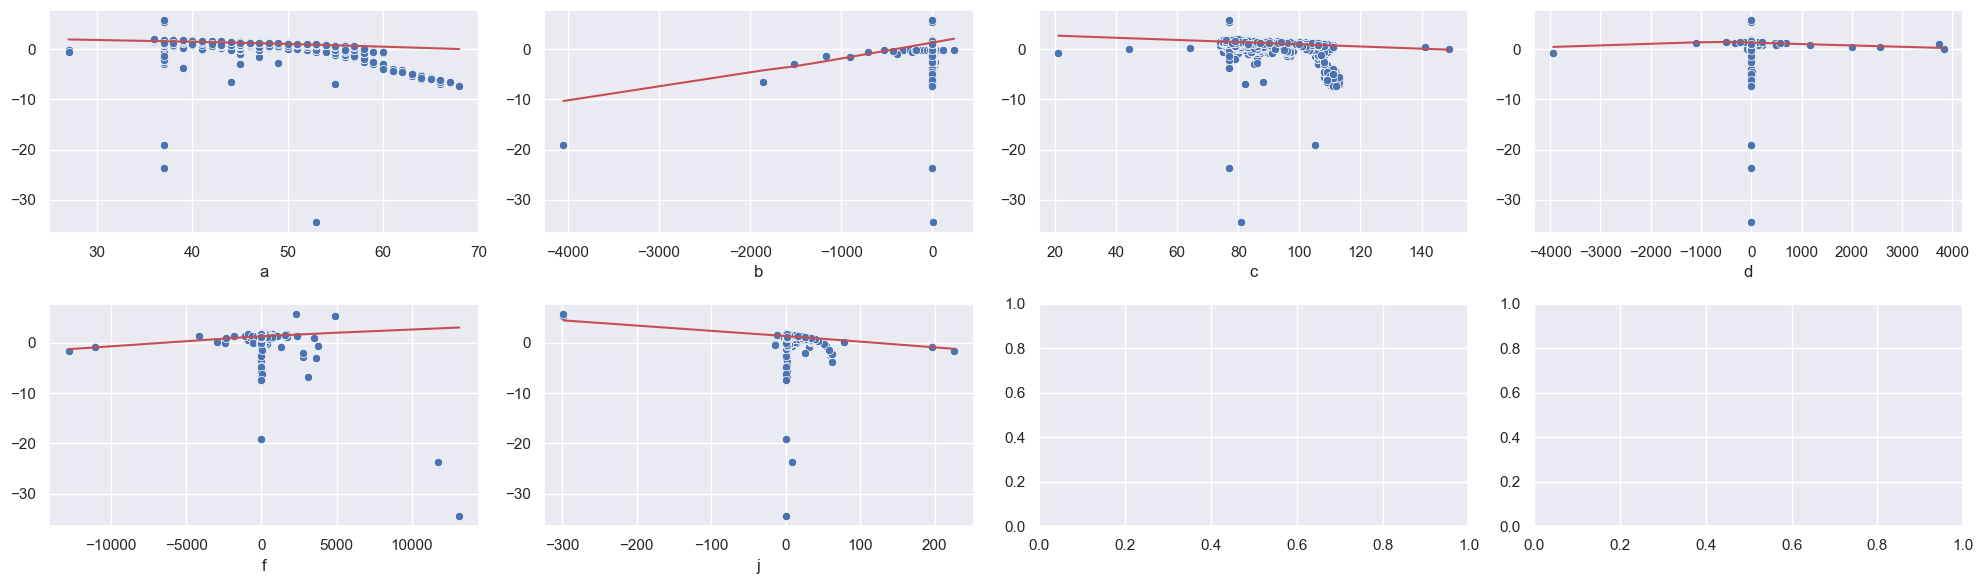

In [28]:
linearity_plot(X, 1, l_odds1)

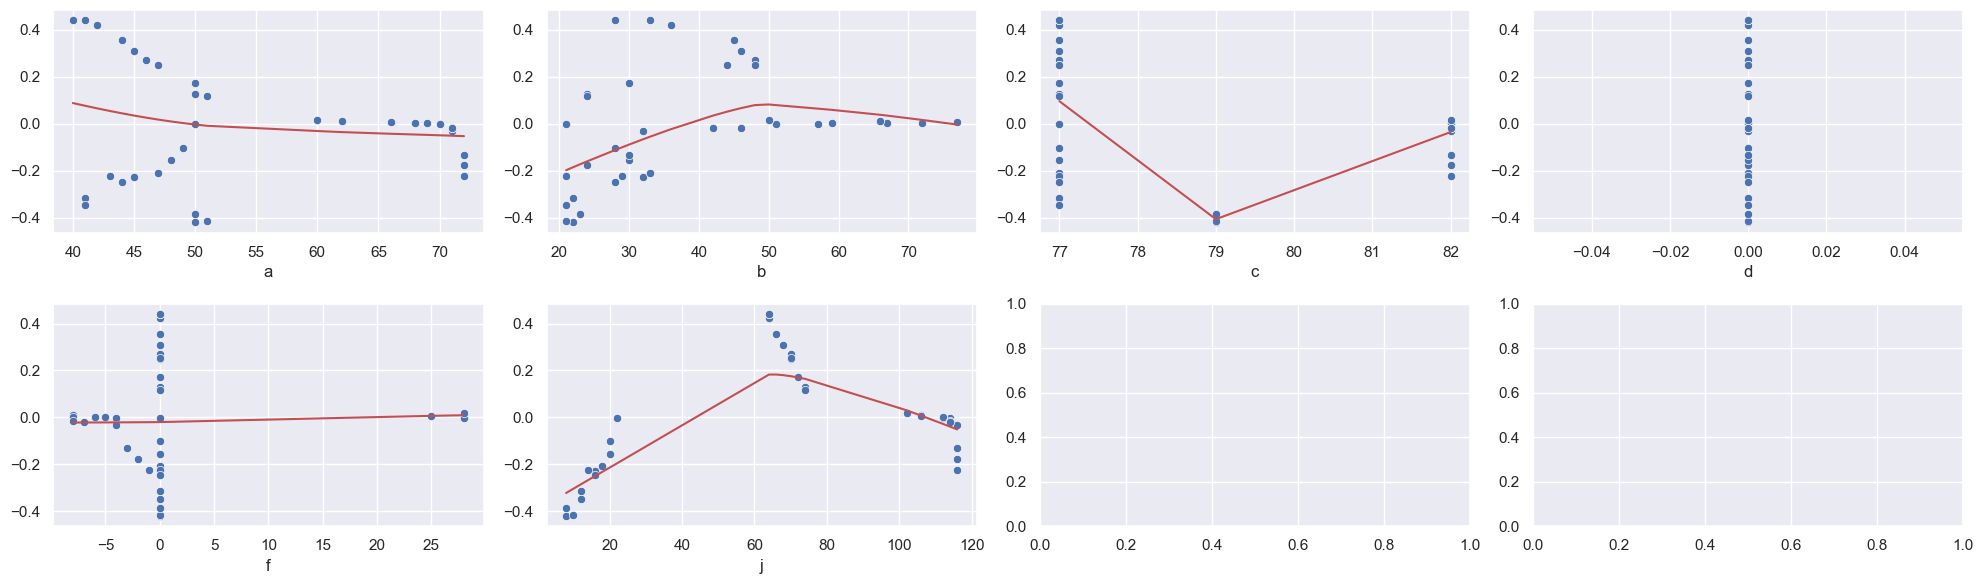

In [29]:
linearity_plot(X, 2, l_odds1)

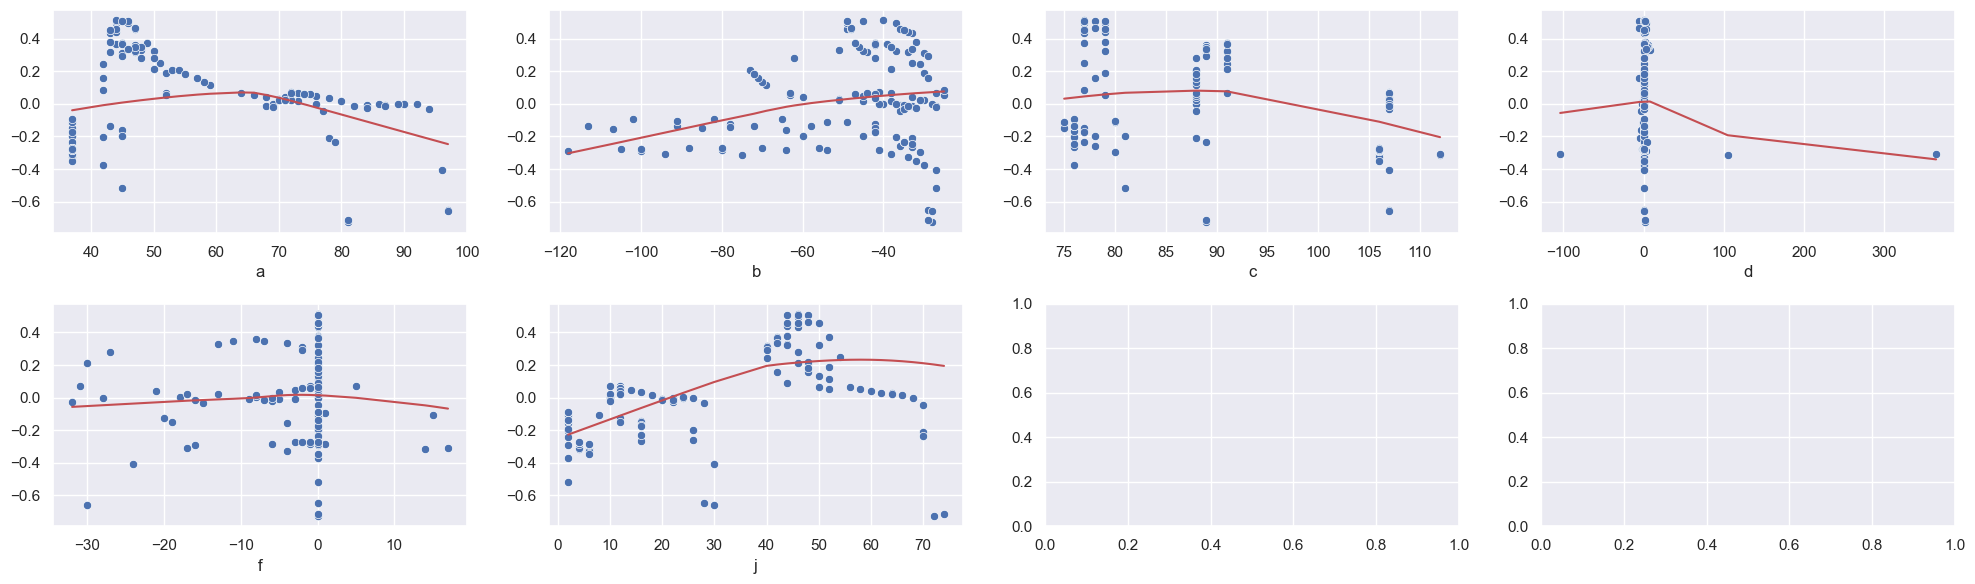

In [30]:
linearity_plot(X, 3, l_odds1)

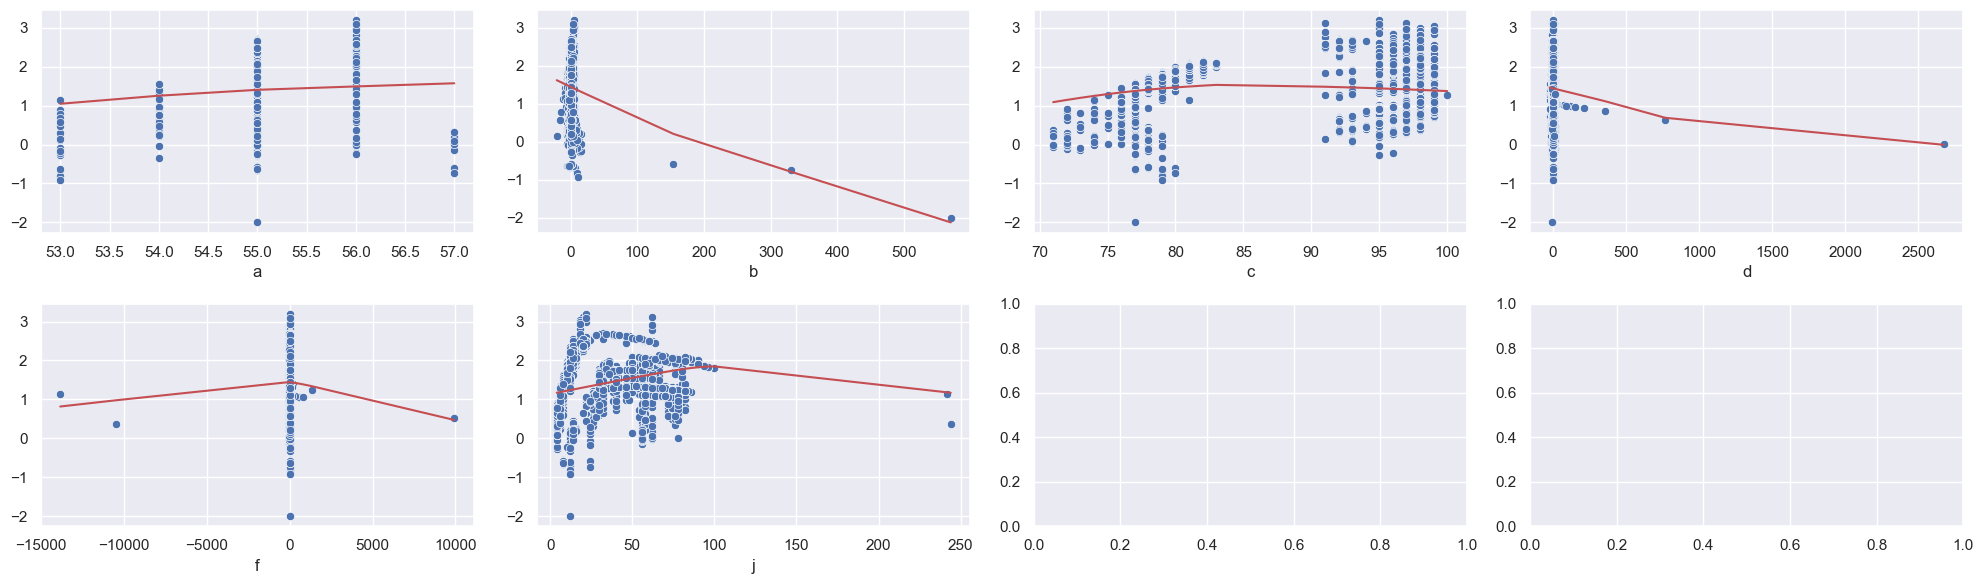

In [31]:
linearity_plot(X, 4, l_odds1)

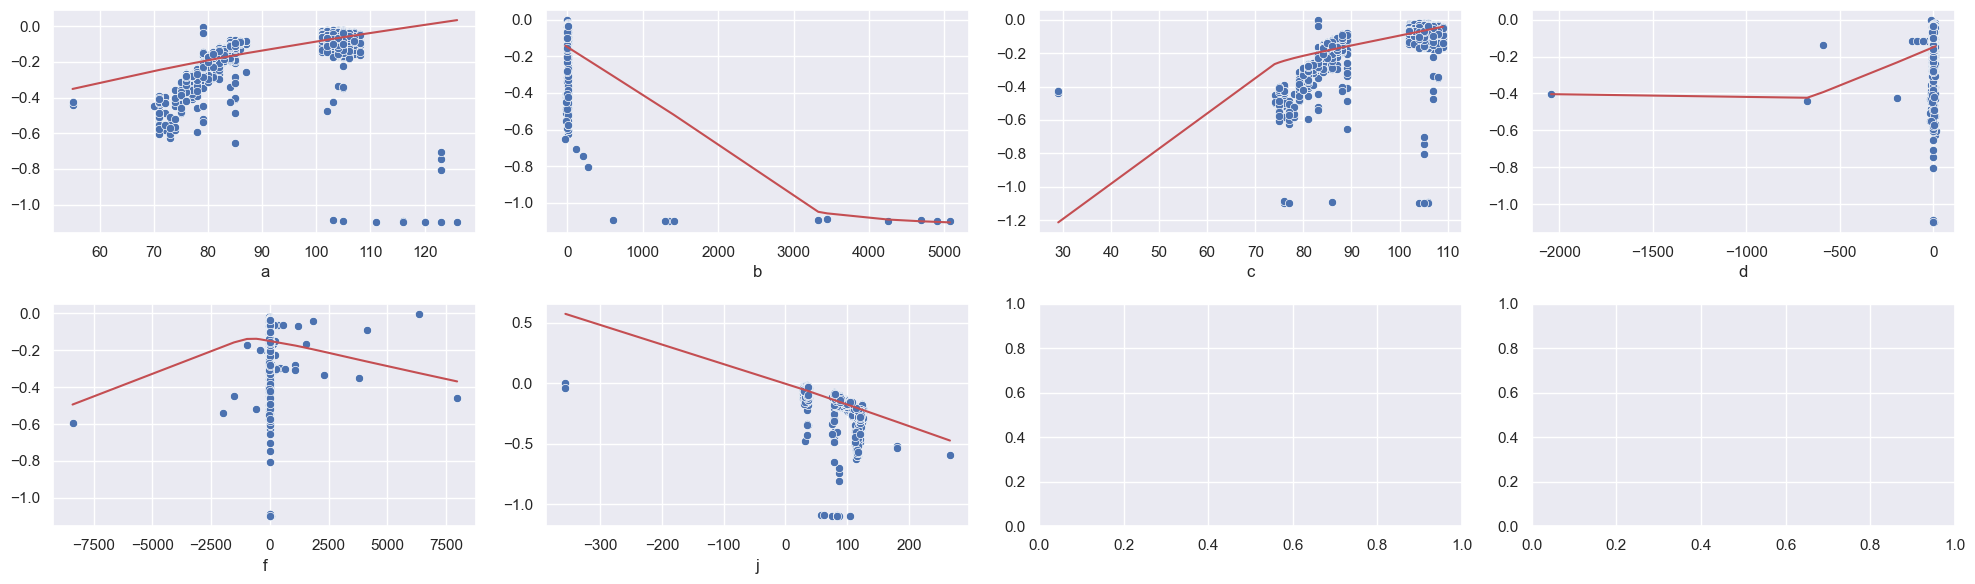

In [32]:
linearity_plot(X, 5, l_odds1)

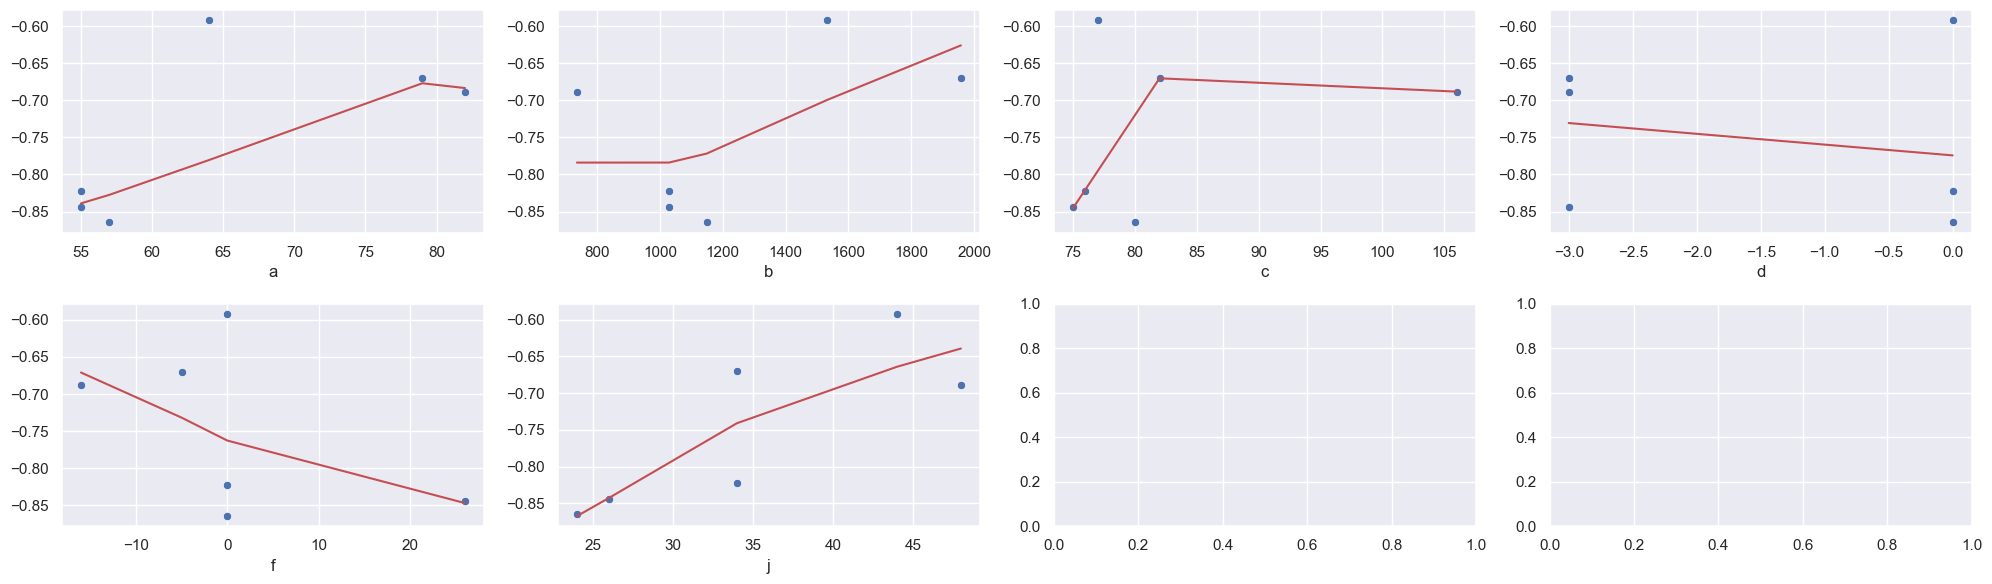

In [33]:
linearity_plot(X, 6, l_odds1)

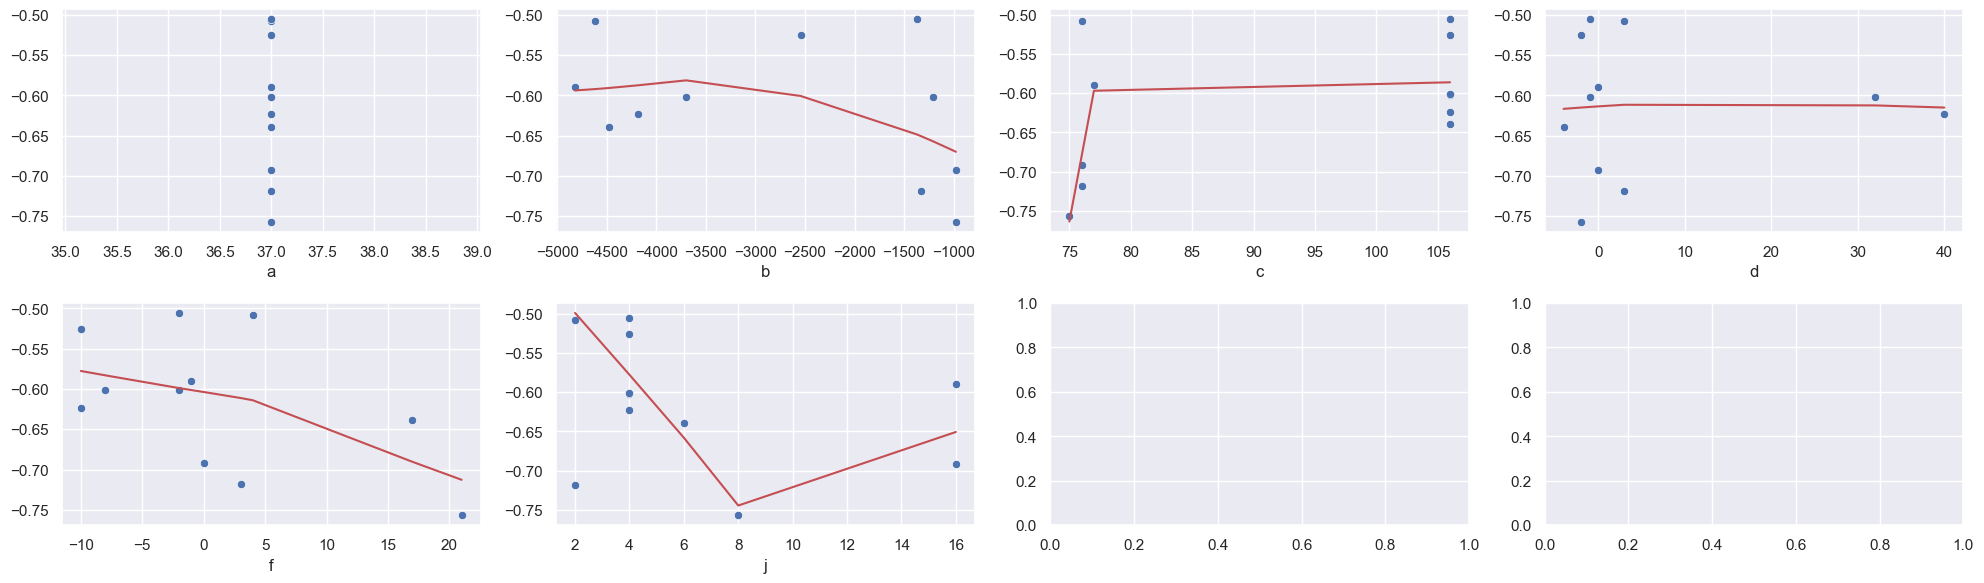

In [34]:
linearity_plot(X, 7, l_odds1)

# Preparing train and test sets

In [35]:
def add_features(orig_X):
    """Add polynomial terms to fix linearity and remove highly correlated features"""
    df = orig_X.copy()
    
    df.drop(columns=['h', 'g', 'e'], inplace=True)
    
    df['b^2'] = df.b ** 2
    df['a^2'] = df.a ** 2
    df['j^2'] = df.j ** 2
    df['c^2'] = df.c ** 2
    df['aj'] = df.a * df.j
    
    return df

In [36]:
poly_train = add_features(train)

In [37]:
poly_test = add_features(test)

In [38]:
# count labels
poly_train.target.value_counts()

1    34108
4     6748
5     2458
3      132
2       37
7       11
6        6
Name: target, dtype: int64

Prepare manually the train and test sets in order to have enough observations in both

In [39]:
def preparing_dataset(X, random_state=0):
    """Balance train and test sets because of classes with small sample"""
    df = X.copy()
    # Fix random state 
    np.random.seed(random_state)
    
    # Create train and test for bigger classes
    tmp_train = df.loc[~df.target.isin([6,7]), :]
    X = tmp_train.drop(columns='target') 
    y = tmp_train['target']
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Create train and test for smaller classes
    tmp_train6 = df.loc[df.target == 6, :]
    tmp_train7 = df.loc[df.target == 7, :]
    
    random6 = np.random.choice(tmp_train6.index)
    random7 = np.random.choice(tmp_train7.index, 2)
    test_indx = [random6, *random7]
    
    tmp_train = df.loc[df.target.isin([6,7]), :]
    tmp_test = tmp_train.loc[test_indx, :]
    tmp_train = tmp_train.loc[~tmp_train.index.isin(test_indx), :]
    
    X_train2 = tmp_train.drop(columns='target') 
    X_test2 = tmp_test.drop(columns='target')
    y_train2 = tmp_train.target
    y_test2 = tmp_test.target
    
    # Join sets
    X_train = pd.concat([X_train1, X_train2])
    X_test = pd.concat([X_test1, X_test2])
    y_train = pd.concat([y_train1, y_train2])
    y_test = pd.concat([y_test1, y_test2])
    
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = preparing_dataset(poly_train)

In [47]:
model2 = LogisticRegression(multi_class='ovr', class_weight='balanced')
model2.fit(X_train, y_train)
pred2 = model2.predict_proba(X_test)
l_odds2 = np.log(pred2 / (1 - pred2))

In [48]:
print(classification_report(y_test, model2.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      0.95      0.97      6769
           2       0.78      1.00      0.88         7
           3       0.66      1.00      0.79        23
           4       0.81      0.99      0.89      1380
           5       1.00      1.00      1.00       518
           6       1.00      1.00      1.00         1
           7       0.67      1.00      0.80         2

    accuracy                           0.96      8700
   macro avg       0.84      0.99      0.90      8700
weighted avg       0.97      0.96      0.96      8700



# Models on train set

Use class_weight to apply weights based on the sample number

In [49]:
def models_on_train_set(X_train, y_train, X_test, y_test):
    """For each model summarize the scores"""
    logistic = LogisticRegression(penalty='l2', C=30, multi_class='ovr', class_weight='balanced')
    neigh = KNeighborsClassifier(n_neighbors=6)
    rforest = RandomForestClassifier(class_weight='balanced', random_state=0, oob_score=True)
    etree = ExtraTreeClassifier(class_weight='balanced', random_state=0)
    gbc = GradientBoostingClassifier(random_state=0)
    vot = VotingClassifier(estimators=[('logistic', logistic), 
                                       ('neigh', neigh), 
                                       ('rforest', rforest), 
                                       ('etree', etree), 
                                       ('gbc', gbc)], voting='hard')

    models = [logistic, neigh, rforest, etree, gbc, vot]
    
    for i in models:
        i.fit(X_train, y_train)
        pred = i.predict(X_test)
        print('='*60)
        print(f'{i}')
        print('='*60)
        print(classification_report(y_test, pred))
        
    return models

In [50]:
models = models_on_train_set(X_train, y_train, X_test, y_test)

LogisticRegression(C=30, class_weight='balanced', multi_class='ovr')
              precision    recall  f1-score   support

           1       1.00      0.95      0.97      6769
           2       0.70      1.00      0.82         7
           3       0.62      1.00      0.77        23
           4       0.80      0.99      0.89      1380
           5       1.00      1.00      1.00       518
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2

    accuracy                           0.96      8700
   macro avg       0.87      0.99      0.92      8700
weighted avg       0.97      0.96      0.96      8700

KNeighborsClassifier(n_neighbors=6)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6769
           2       1.00      0.71      0.83         7
           3       0.75      0.78      0.77        23
           4       1.00      1.00      1.00      1380
           5       0.99    

# Models on test set

In [51]:
def models_on_test_set(X, models):
    """For each model summarize the scores"""    
    for i in models:
        pred = i.predict(X.drop(columns='target'))
        print('='*60)
        print(f'{i}')
        print('='*60)
        print(classification_report(X.target, pred))

In [52]:
models_on_test_set(poly_test, models)

LogisticRegression(C=30, class_weight='balanced', multi_class='ovr')
              precision    recall  f1-score   support

           1       1.00      0.94      0.97     11478
           2       0.76      1.00      0.87        13
           3       0.76      1.00      0.87        39
           4       0.77      1.00      0.87      2155
           5       1.00      1.00      1.00       809
           6       1.00      1.00      1.00         4
           7       0.29      1.00      0.44         2

    accuracy                           0.95     14500
   macro avg       0.80      0.99      0.86     14500
weighted avg       0.96      0.95      0.96     14500

KNeighborsClassifier(n_neighbors=6)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     11478
           2       0.82      0.69      0.75        13
           3       0.88      0.92      0.90        39
           4       1.00      1.00      1.00      2155
           5       1.00    